# Library Installation

In [ ]:
#apt-get update
#apt install tesseract-ocr
#apt-get install tesseract-ocr-deu
#pip install pytesseract
#!pip install split-folders

In [ ]:
#!pip install ipywidgets
#!pip install widgetsnbextension
#!jupyter nbextension enable --py widgetsnbextension

# Library Import

In [1]:
import sys
import os
from os.path import dirname

#path to image and text models
sys.path.append("../src/models/")

In [2]:
import pytesseract
from pytesseract import Output

import product_recognition_image_model as prm
import product_recognition_text_model as prtm

import torch
from PIL import Image
import numpy as np
import pandas as pd
from scipy.special import softmax
import threading

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import datetime
import pickle

import cv2

import splitfolders

%load_ext autoreload
%autoreload 2

In [3]:
import sklearn
sklearn.__version__

'0.24.2'

In [4]:
pytesseract.get_tesseract_version()

<Version('4.1.1')>

In [5]:
torch.__version__

'1.12.0a0+bd13bc6'

In [6]:
# GPU Used:
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 3090'

# Validation/Test Split

In [ ]:
test_folders = "../data/raw/products_leaflets_256/test"
val_test_split_path = "../data/raw/products_leaflets_256/val_test_split"

splitfolders.ratio(test_folders, output=val_test_split_path,
    seed=1, ratio=(.5, .5), group_prefix=None, move=False)

test_folders = "../data/raw/products_leaflets_512/test"
val_test_split_path = "../data/raw/products_leaflets_512/val_test_split"

splitfolders.ratio(test_folders, output=val_test_split_path,
    seed=1, ratio=(.5, .5), group_prefix=None, move=False)

# splitfolders splits in train/val, rename in test/val
os.rename("../data/raw/products_leaflets_256/val_test_split/train", "../data/raw/products_leaflets_256/val_test_split/test")
os.rename("../data/raw/products_leaflets_512/val_test_split/train", "../data/raw/products_leaflets_512/val_test_split/test")


# Helper Functions

In [7]:
def top_k_calc_from_probas(probas, truth_label_index, top_k = 5):
    results = []
    indexes = []
    real_class_indexes = []
    for count, entry in enumerate(probas):
        top_k_indexes = np.flip(np.argsort(entry)[-top_k:])
        real_class_index = []
        for x in top_k_indexes:
            real_class_index.append(pRMModel.get_real_class_from_dataloader(selected_dataloader, x))
        indexes.append(top_k_indexes)
        real_class_indexes.append(real_class_index)
        if truth_label_index[count] in top_k_indexes:
            results.append(True)
        else:
            results.append(False)
    return results.count(True)/len(results), results, indexes, real_class_indexes

#Text extraction Helper ------

def sortClassesNumerical(classArray):
    resultArray = []
    for i in classArray:
        try:
            resultArray.append(int(i))
        except:
            print("Could not convert:", i)
    return resultArray

def sortImages(stringImageArray):
    resultArray = []
    for i in stringImageArray:
        try:
            resultArray.append(int(i[0:-4]))
        except:
            print("Could not convert:", i)
    sortedArray = np.sort(resultArray)
    
    resultArray = []
    for i in sortedArray:
        resultArray.append(str(i) +".jpg")
    return resultArray

def createFullSortedImageList(path):
    complete_df = pd.DataFrame(columns=["image_id", "truth_label"])
    sorted_classes = np.sort(sortClassesNumerical(os.listdir(path)))
    class_df = pd.DataFrame()
    for count, className in enumerate(sorted_classes):
        class_image_list = sortImages(os.listdir(path + "/" + str(className)))
        for image_name in class_image_list:
            complete_df.loc[len(complete_df.index)] = [(str(className) + "/" + image_name), className]
    return complete_df

def extract_text_from_imagepath_df(text_preprocessing, image_path, extract_image_df, extraction_name, phase, 
                                   save_interval = 2000, progress_inteval = 500):
    extraction_name = extraction_name + "_" + phase + "_"
    extraction_method_names = []
    for i in text_preprocessing.extraction_methods:
        extraction_method_names.append(i.__name__)

    progress_inteval = progress_inteval
    start_time = datetime.datetime.now()
    print("Start:", start_time)
    result_df = pd.DataFrame(columns= ["extraction_id"] + extraction_method_names)
    for index, row in extract_image_df.iterrows():
        sample_image_path = image_path + "/" + row["image_id"]
        img = mpimg.imread(sample_image_path)
        ocr_string = text_preprocessing.ocr_image(img, return_single_results = True)
        result_df.loc[len(result_df.index)] = [index] + ocr_string
        
        if index%progress_inteval == 0:
            print(index, '{:.4f}'.format(index/len(extract_image_df)) + "% -", datetime.datetime.now())  
            
        # fix if shared memory is filled by tesseract memory allocation not freed bug --
        """
        # clear shared memory folder
        if (index%500 == 0):
            print("SHM Folder Size:", os.path.getsize("../../../../../dev/shm"))
            print("Clear SHM Directory")
            os.system("rm ../../../../../dev/shm/*")
            print("SHM Folder Size:", os.path.getsize("../../../../../dev/shm"))
        # ---
        """
        
        if (index != 0) and (index%save_interval == 0):
            result_df.to_pickle(save_path + extraction_name + str(index) + ".pkl")
            result_df = pd.DataFrame(columns= ["extraction_id"] + extraction_method_names)
    result_df.to_pickle(save_path + extraction_name + str(index) + ".pkl")
    end_time = datetime.datetime.now()
    print("End:", end_time)
    print("Duration:", end_time - start_time)
    
    # combine all extraction checkpoints to one complete dataframe
    df_extract_complete = pd.DataFrame()
    df_length = len(extract_image_df)
    for i in range(save_interval, df_length, save_interval):
        if i == save_interval:
            df_extract_complete = pd.read_pickle(save_path + extraction_name + str(i) +".pkl")
        else:
            tempDF = pd.read_pickle(save_path + extraction_name + str(i) +".pkl")
            df_extract_complete = pd.concat([df_extract_complete, tempDF], axis = 0).reset_index(drop=True)
    tempDF = pd.read_pickle(save_path + extraction_name + str(df_length-1) +".pkl")
    df_extract_complete = pd.concat([df_extract_complete, tempDF], axis = 0).reset_index(drop=True)
    df_extract_complete.to_pickle(save_path + extraction_name + "_complete" + ".pkl")

#------

# Image Model

In [8]:
train_data_path = "../data/raw/products_leaflets_256/train"
test_data_path = "../data/raw/products_leaflets_256/val_test_split/test"
val_data_path = "../data/raw/products_leaflets_256/val_test_split/val"
save_path  = "../data/processed/ocr-results/pickle/"

In [9]:
pRMModel = prm.productRecognitionImageModel()
pRMModel.set_configuration()
pRMModel.initialize_dataloader(train_data_path = train_data_path, test_data_path = test_data_path, val_data_path = val_data_path)
pRMModel.initialize_model()

Device: cuda:0


In [10]:
# get Image Order from dataloader to keep order
selected_dataloader = pRMModel.dataloaders["validation"]
test_image_paths = selected_dataloader.dataset.imgs
test_image_model_labels = [x[1] for x in test_image_paths]
test_image_paths = [x[0] for x in test_image_paths]
test_image_paths_512 = [x.replace("_256", "_512") for x in test_image_paths]

df_test_images = pd.DataFrame()
df_test_images["image_paths"] = test_image_paths_512

result_df = pd.DataFrame()
result_df["image_paths"] = test_image_paths
result_df["truth_labels"] = test_image_model_labels

In [51]:
#train image model
trained_model = pRMModel.train_model(30)

Epoch 1/30
----------
train loss: 4.8151, acc: 0.1895
Training complete in 2m 46s


/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


validation loss: 1.5087, acc: 0.6654
Training complete in 2m 55s
Epoch 2/30
----------
train loss: 0.7066, acc: 0.8474
Training complete in 2m 46s
validation loss: 0.5409, acc: 0.8707
Training complete in 2m 55s
Epoch 3/30
----------
train loss: 0.2075, acc: 0.9524
Training complete in 2m 46s
validation loss: 0.4903, acc: 0.8887
Training complete in 2m 54s
Epoch 4/30
----------
train loss: 0.1055, acc: 0.9759
Training complete in 2m 46s
validation loss: 0.4335, acc: 0.9022
Training complete in 2m 55s
Epoch 5/30
----------
train loss: 0.0602, acc: 0.9860
Training complete in 2m 46s
validation loss: 0.4498, acc: 0.9060
Training complete in 2m 55s
Epoch 6/30
----------
train loss: 0.0352, acc: 0.9925
Training complete in 2m 45s
validation loss: 0.4272, acc: 0.9156
Training complete in 2m 54s
Epoch 7/30
----------
train loss: 0.0248, acc: 0.9957
Training complete in 2m 45s
validation loss: 0.4398, acc: 0.9139
Training complete in 2m 54s
Epoch 8/30
----------
train loss: 0.0166, acc: 0.9968

In [52]:
# load best epoch weights
pRMModel.load_best_epoch_weights()
pRMModel.model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [53]:
#save model weights
#torch.save(pRMModel.model.state_dict(), '../src/models/weights/resnet_50_transfer_tuned_f.h5')

In [11]:
# load weights
pRMModel.model.load_state_dict(torch.load('../src/models/weights/resnet_50_transfer_tuned_f.h5'))
pRMModel.model.eval()
torch.cuda.memory_allocated(0)/1024/1024 #allocated MB

101.3564453125

In [12]:
%%time
# predict by dataloader
result, probas = pRMModel.predict_from_dataloader_probas(selected_dataloader)
confidence = [x[0] for x in result]
predictions = [x[1] for x in result]
result_df["image_confidence"] = confidence
result_df["image_prediction"] = predictions

CPU times: user 1min 14s, sys: 1.28 s, total: 1min 16s
Wall time: 10.4 s


In [13]:
top_k_number = 1
top_k_acc, top_k_results, image_indexes, _ = top_k_calc_from_probas(probas, result_df["truth_labels"].values, top_k_number)
result_df["in_top_" + str(top_k_number)] = top_k_results
top_k_acc

0.9288461538461539

In [14]:
top_k_number = 3
top_k_acc, top_k_results, image_indexes, _ = top_k_calc_from_probas(probas, result_df["truth_labels"].values, top_k_number)
result_df["in_top_" + str(top_k_number)] = top_k_results
top_k_acc

0.9675480769230769

In [15]:
top_k_number = 5
top_k_acc, top_k_results, image_indexes, _ = top_k_calc_from_probas(probas, result_df["truth_labels"].values, top_k_number)
result_df["in_top_" + str(top_k_number)] = top_k_results
top_k_acc

0.9740384615384615

# Text Extraction

In [16]:
dataset_path_train = "../data/raw/products_leaflets_512/train"
dataset_path_test = "../data/raw/products_leaflets_512/val_test_split/test"
dataset_path_val = "../data/raw/products_leaflets_512/val_test_split/val"
save_path = "../data/processed/ocr-results/pickle/"

In [17]:
df_text_extraction_base = "paper_extraction"

In [18]:
%%time
res = createFullSortedImageList(dataset_path_train)
res.to_pickle(save_path + df_text_extraction_base + "_train" + ".pkl")

res = createFullSortedImageList(dataset_path_test)
res.to_pickle(save_path + df_text_extraction_base + "_test" + ".pkl")

res = createFullSortedImageList(dataset_path_val)
res.to_pickle(save_path + df_text_extraction_base + "_val" + ".pkl")
del res

CPU times: user 57.4 s, sys: 56.9 ms, total: 57.4 s
Wall time: 57.5 s


In [18]:
train_image_df = pd.read_pickle(save_path + df_text_extraction_base + "_train" + ".pkl")
test_image_df = pd.read_pickle(save_path + df_text_extraction_base + "_test" + ".pkl")
val_image_df = pd.read_pickle(save_path + df_text_extraction_base + "_val" + ".pkl")

In [19]:
train_image_df.head()

,image_id,truth_label
0,0/1.jpg,0
1,0/2.jpg,0
2,0/3.jpg,0
3,0/4.jpg,0
4,0/5.jpg,0


## Extract Text - Train Data

In [23]:
phase = "train"
image_path = dataset_path_train
extract_image_df = train_image_df.copy()
extraction_name = df_text_extraction_base + "_" + phase + "_"

In [24]:
text_preprocessing = prtm.ocrExtraction()

In [86]:
# possibility to select only some methods
#text_preprocessing.extraction_methods = text_preprocessing.extraction_methods[0:2]

In [23]:
extract_text_from_imagepath_df(text_preprocessing, image_path, extract_image_df, 
                               extraction_name = df_text_extraction_base, phase=phase, save_interval=500)

Start: 2023-05-02 16:04:06.516304
0 0.0000% - 2023-05-02 16:04:07.598902
SHM Folder Size: 1660
Clear SHM Directory
SHM Folder Size: 40
500 0.0150% - 2023-05-02 16:10:51.992724
SHM Folder Size: 80040
Clear SHM Directory
SHM Folder Size: 40
1000 0.0300% - 2023-05-02 16:17:45.011630
SHM Folder Size: 80040
Clear SHM Directory
SHM Folder Size: 40
1500 0.0451% - 2023-05-02 16:24:33.928575
SHM Folder Size: 80040
Clear SHM Directory
SHM Folder Size: 40
2000 0.0601% - 2023-05-02 16:31:27.747568
SHM Folder Size: 80040
Clear SHM Directory
SHM Folder Size: 40
2500 0.0751% - 2023-05-02 16:38:30.489893
SHM Folder Size: 80040
Clear SHM Directory
SHM Folder Size: 40
3000 0.0901% - 2023-05-02 16:44:59.579235
SHM Folder Size: 80040
Clear SHM Directory
SHM Folder Size: 40
3500 0.1052% - 2023-05-02 16:52:16.300995
SHM Folder Size: 80040
Clear SHM Directory
SHM Folder Size: 40
4000 0.1202% - 2023-05-02 16:59:26.703472
SHM Folder Size: 80040
Clear SHM Directory
SHM Folder Size: 40
4500 0.1352% - 2023-05-02 

In [25]:
tempDF = pd.read_pickle(save_path + extraction_name + "_complete" + ".pkl")

In [26]:
# add image_id and truth label to extraction df
tempDF["image_id"] = train_image_df["image_id"]
tempDF["truth_labels"] = train_image_df["truth_label"]

#combine all extracted strings 
tempDF["ocr_all"] = ""
for i in tempDF.columns:
    if i.startswith("ocr_extract"):
        tempDF["ocr_all"] = tempDF["ocr_all"] + " " + tempDF[i]

In [27]:
main_extraction_df = tempDF[["extraction_id", "image_id", "truth_labels", "ocr_all"]].copy()
main_extraction_df.to_pickle(save_path + extraction_name + "_main" + ".pkl")

In [28]:
main_extraction_df.head()

,extraction_id,image_id,truth_labels,ocr_all
0,0,0/1.jpg,0,| Rügen Fisch\n| Scomher Mix\n\n \n\n \n ...
1,1,0/2.jpg,0,"‚dene Sorten, 120 g Dose,\n100 g = 0,66\n\n \..."
2,2,0/3.jpg,0,\n \n\n \n\nPe 9\n2\nRügenfisch\nScomber...
3,3,0/4.jpg,0,Rügenfisch\nScomber Mix\nMakrelenfilets in Ma...
4,4,0/5.jpg,0,\n\naus Norddeutschland\n\nRügenfFisch\nScom...


In [29]:
del tempDF 
del main_extraction_df

## Extract Text - Val Data

In [30]:
phase = "val"
image_path = dataset_path_val
extract_image_df = val_image_df.copy()
extraction_name = df_text_extraction_base + "_" + phase + "_"

In [31]:
text_preprocessing = prtm.ocrExtraction()

In [23]:
# possibility to select only some methods
#text_preprocessing.extraction_methods = text_preprocessing.extraction_methods[0:2]

In [24]:
extract_text_from_imagepath_df(text_preprocessing, image_path, extract_image_df, 
                               extraction_name = df_text_extraction_base, phase=phase, save_interval=500)

Start: 2023-05-03 11:32:10.758050
0 0.0000% - 2023-05-03 11:32:11.814647
SHM Folder Size: 1660
Clear SHM Directory
SHM Folder Size: 40
500 0.1202% - 2023-05-03 11:39:30.957451
SHM Folder Size: 80040
Clear SHM Directory
SHM Folder Size: 40
1000 0.2404% - 2023-05-03 11:46:50.576338
SHM Folder Size: 80040
Clear SHM Directory
SHM Folder Size: 40
1500 0.3606% - 2023-05-03 11:54:00.481421
SHM Folder Size: 80040
Clear SHM Directory
SHM Folder Size: 40
2000 0.4808% - 2023-05-03 12:01:03.185302
SHM Folder Size: 80040
Clear SHM Directory
SHM Folder Size: 40
2500 0.6010% - 2023-05-03 12:08:09.931007
SHM Folder Size: 80040
Clear SHM Directory
SHM Folder Size: 40
3000 0.7212% - 2023-05-03 12:15:13.867232
SHM Folder Size: 80040
Clear SHM Directory
SHM Folder Size: 40
3500 0.8413% - 2023-05-03 12:22:25.155367
SHM Folder Size: 80040
Clear SHM Directory
SHM Folder Size: 40
4000 0.9615% - 2023-05-03 12:29:29.872711
SHM Folder Size: 80040
Clear SHM Directory
SHM Folder Size: 40
End: 2023-05-03 12:31:41.9

In [32]:
tempDF = pd.read_pickle(save_path + extraction_name + "_complete" + ".pkl")

In [34]:
# add image_id and truth label to extraction df
tempDF["image_id"] = val_image_df["image_id"]
tempDF["truth_labels"] = val_image_df["truth_label"]

#combine all extracted strings 
tempDF["ocr_all"] = ""
for i in tempDF.columns:
    if i.startswith("ocr_extract"):
        tempDF["ocr_all"] = tempDF["ocr_all"] + " " + tempDF[i]

In [35]:
main_extraction_df = tempDF[["extraction_id", "image_id", "truth_labels", "ocr_all"]].copy()
main_extraction_df.to_pickle(save_path + extraction_name + "_main" + ".pkl")

In [36]:
main_extraction_df.head()

,extraction_id,image_id,truth_labels,ocr_all
0,0,0/0.jpg,0,\n\nScanber Mix\n\n \n \n \n\n \n \n ...
1,1,0/17.jpg,0,\n\nRügenFisch\nScomber Mix\n\nMakrelenfilet...
2,2,0/18.jpg,0,\n\nRügenFisch\nScomber Mix\n\nMakrelenfilet...
3,3,0/19.jpg,0,\n\nRügenFisch\nScomber Mix\n\nMakrelenfilet...
4,4,0/24.jpg,0,\n \n\nScomber Mir\n \n u r nn\nf en P...


In [37]:
del tempDF 
del main_extraction_df

## Extract Text - Test Data

In [38]:
phase = "test"
image_path = dataset_path_test
extract_image_df = test_image_df.copy()
extraction_name = df_text_extraction_base + "_" + phase + "_"

In [39]:
text_preprocessing = prtm.ocrExtraction()

In [41]:
# possibility to select only some methods
#text_preprocessing.extraction_methods = text_preprocessing.extraction_methods[0:2]

In [32]:
extract_text_from_imagepath_df(text_preprocessing, image_path, extract_image_df, 
                               extraction_name = df_text_extraction_base, phase=phase, save_interval=500)

Start: 2023-05-03 12:31:42.136751
0 0.0000% - 2023-05-03 12:31:42.853512
SHM Folder Size: 25640
Clear SHM Directory
SHM Folder Size: 40
500 0.1202% - 2023-05-03 12:38:45.935670
SHM Folder Size: 80040
Clear SHM Directory
SHM Folder Size: 40
1000 0.2404% - 2023-05-03 12:45:51.913785
SHM Folder Size: 80040
Clear SHM Directory
SHM Folder Size: 40
1500 0.3606% - 2023-05-03 12:53:00.313456
SHM Folder Size: 80040
Clear SHM Directory
SHM Folder Size: 40
2000 0.4808% - 2023-05-03 13:00:07.564043
SHM Folder Size: 80040
Clear SHM Directory
SHM Folder Size: 40
2500 0.6010% - 2023-05-03 13:07:15.079515
SHM Folder Size: 80040
Clear SHM Directory
SHM Folder Size: 40
3000 0.7212% - 2023-05-03 13:14:19.391341
SHM Folder Size: 80040
Clear SHM Directory
SHM Folder Size: 40
3500 0.8413% - 2023-05-03 13:21:24.878409
SHM Folder Size: 80040
Clear SHM Directory
SHM Folder Size: 40
4000 0.9615% - 2023-05-03 13:28:34.990998
SHM Folder Size: 80040
Clear SHM Directory
SHM Folder Size: 40
End: 2023-05-03 13:30:48.

In [40]:
tempDF = pd.read_pickle(save_path + extraction_name + "_complete" + ".pkl")

In [41]:
# add image_id and truth label to extraction df
tempDF["image_id"] = test_image_df["image_id"]
tempDF["truth_labels"] = test_image_df["truth_label"]

#combine all extracted strings 
tempDF["ocr_all"] = ""
for i in tempDF.columns:
    if i.startswith("ocr_extract"):
        tempDF["ocr_all"] = tempDF["ocr_all"] + " " + tempDF[i]

In [42]:
main_extraction_df = tempDF[["extraction_id", "image_id", "truth_labels", "ocr_all"]].copy()
main_extraction_df.to_pickle(save_path + extraction_name + "_main" + ".pkl")

In [43]:
main_extraction_df.head()

,extraction_id,image_id,truth_labels,ocr_all
0,0,0/25.jpg,0,\n \n >\n\nScomberiiit\n\n-1%\n\n86\n >\...
1,1,0/26.jpg,0,2\nIR\n\naus Sasentz in Scomber\nMecklenburg\...
2,2,0/47.jpg,0,\n\nstatt 2.97\n\n \n \n De - FE\nA er\...
3,3,0/48.jpg,0,"\n\nScomber Mix\n\nwersch. Sörtem,\n\n#0 Abt..."
4,4,0/49.jpg,0,\n\nRügenfisch\nScomber Mix\nversch. Sorte...


In [44]:
del tempDF 
del main_extraction_df

# Text Model

In [46]:
save_path = "../../data/processed/ocr-results/pickle/"
df_train = pd.read_pickle(save_path + df_text_extraction_base + "_" + "train" + "_" + "_main" + ".pkl")
df_val =  pd.read_pickle(save_path + df_text_extraction_base + "_" + "val" + "_" + "_main" + ".pkl")
df_test =  pd.read_pickle(save_path + df_text_extraction_base + "_" + "test" + "_" + "_main" + ".pkl")

df_train["truth_labels"] = df_train["truth_labels"].astype(str)
df_val["truth_labels"] = df_val["truth_labels"].astype(str)
df_test["truth_labels"] = df_test["truth_labels"].astype(str)

In [47]:
text_model = prtm.productRecognitionTextModel()
text_model.train_vocab(df_train["ocr_all"])
text_model.train(text_model.transform(df_train["ocr_all"]), df_train["truth_labels"])

SGDClassifier(eta0=1, learning_rate='adaptive', loss='modified_huber',
              random_state=0)

In [ ]:
#save model
#with open('../src/models/weights/text_model_save.pkl','wb') as f:
#    pickle.dump(text_model,f)

In [ ]:
# load Text model
#with open('../src/models/weights/text_model_save.pkl', 'rb') as f:
#    text_model = pickle.load(f)

In [48]:
df_text_pred = df_val.copy()

In [49]:
#sort to adjust order to image dataloader prediction
df_text_pred = df_text_pred.sort_values("image_id").reset_index(drop=True)

truth_indexes = []
for i in df_text_pred["truth_labels"].values:
    truth_indexes.append(selected_dataloader.dataset.class_to_idx[i])
df_text_pred["truth_labels"] = truth_indexes

In [50]:
transformation = text_model.transform(df_text_pred["ocr_all"])
text_preds = text_model.predict(transformation)
text_probas = text_model.model.predict_proba(transformation)
text_dec_probas = text_model.model.decision_function(transformation)

In [51]:
top_k_number = 1
top_k_acc, top_k_results, text_indexes, _ = top_k_calc_from_probas(text_dec_probas, df_text_pred["truth_labels"].values, top_k_number)
result_df["in_top_" + str(top_k_number)] = top_k_results
top_k_acc

0.9264423076923077

# Model Combination

In [52]:
weighting_count = []
weighting_result_accuracys = []
for i_weighting in range(1, 200):
    weighting_count.append(i_weighting)
    softmax_probas = []
    softmax_text_probas = []
    combined_softmax_probas = []
    for i in range(0, len(probas)):
        softmax_probas.append(softmax(probas[i]))
        softmax_text_probas.append(softmax(text_dec_probas[i])*10 *i_weighting)
        combined_softmax_probas.append(softmax_probas[-1]+ softmax_text_probas[-1])

    combined_probas = combined_softmax_probas

    top_k_number = 1
    top_k_acc, top_k_results, combined_indexes, combined_real_class_indexes = top_k_calc_from_probas(combined_probas, df_text_pred["truth_labels"].values, top_k_number)
    result_df["in_top_" + str(top_k_number)] = top_k_results
    print(i_weighting, top_k_acc)
    weighting_result_accuracys.append(top_k_acc)
    

1 0.9288461538461539
2 0.9288461538461539
3 0.9288461538461539
4 0.9288461538461539
5 0.9290865384615384
6 0.9290865384615384
7 0.9290865384615384
8 0.9293269230769231
9 0.9293269230769231
10 0.9295673076923077
11 0.9302884615384616
12 0.9307692307692308
13 0.9314903846153846
14 0.932451923076923
15 0.9334134615384615
16 0.9346153846153846
17 0.9360576923076923
18 0.9375
19 0.9389423076923077
20 0.9401442307692308
21 0.9411057692307693
22 0.9427884615384615
23 0.9435096153846154
24 0.9449519230769231
25 0.9456730769230769
26 0.9459134615384616
27 0.9473557692307693
28 0.948076923076923
29 0.9492788461538462
30 0.95
31 0.9504807692307692
32 0.9509615384615384
33 0.9526442307692308
34 0.9533653846153847
35 0.9543269230769231
36 0.9545673076923077
37 0.9557692307692308
38 0.9567307692307693
39 0.9569711538461538
40 0.9576923076923077
41 0.9584134615384615
42 0.9591346153846154
43 0.959375
44 0.9600961538461539
45 0.9600961538461539
46 0.9603365384615384
47 0.9603365384615384
48 0.96081730

In [53]:
best_weight = np.argmax(weighting_result_accuracys) #87
best_weight_accuracy = np.max(weighting_result_accuracys)
print(best_weight)
print(best_weight_accuracy)

93
0.96875


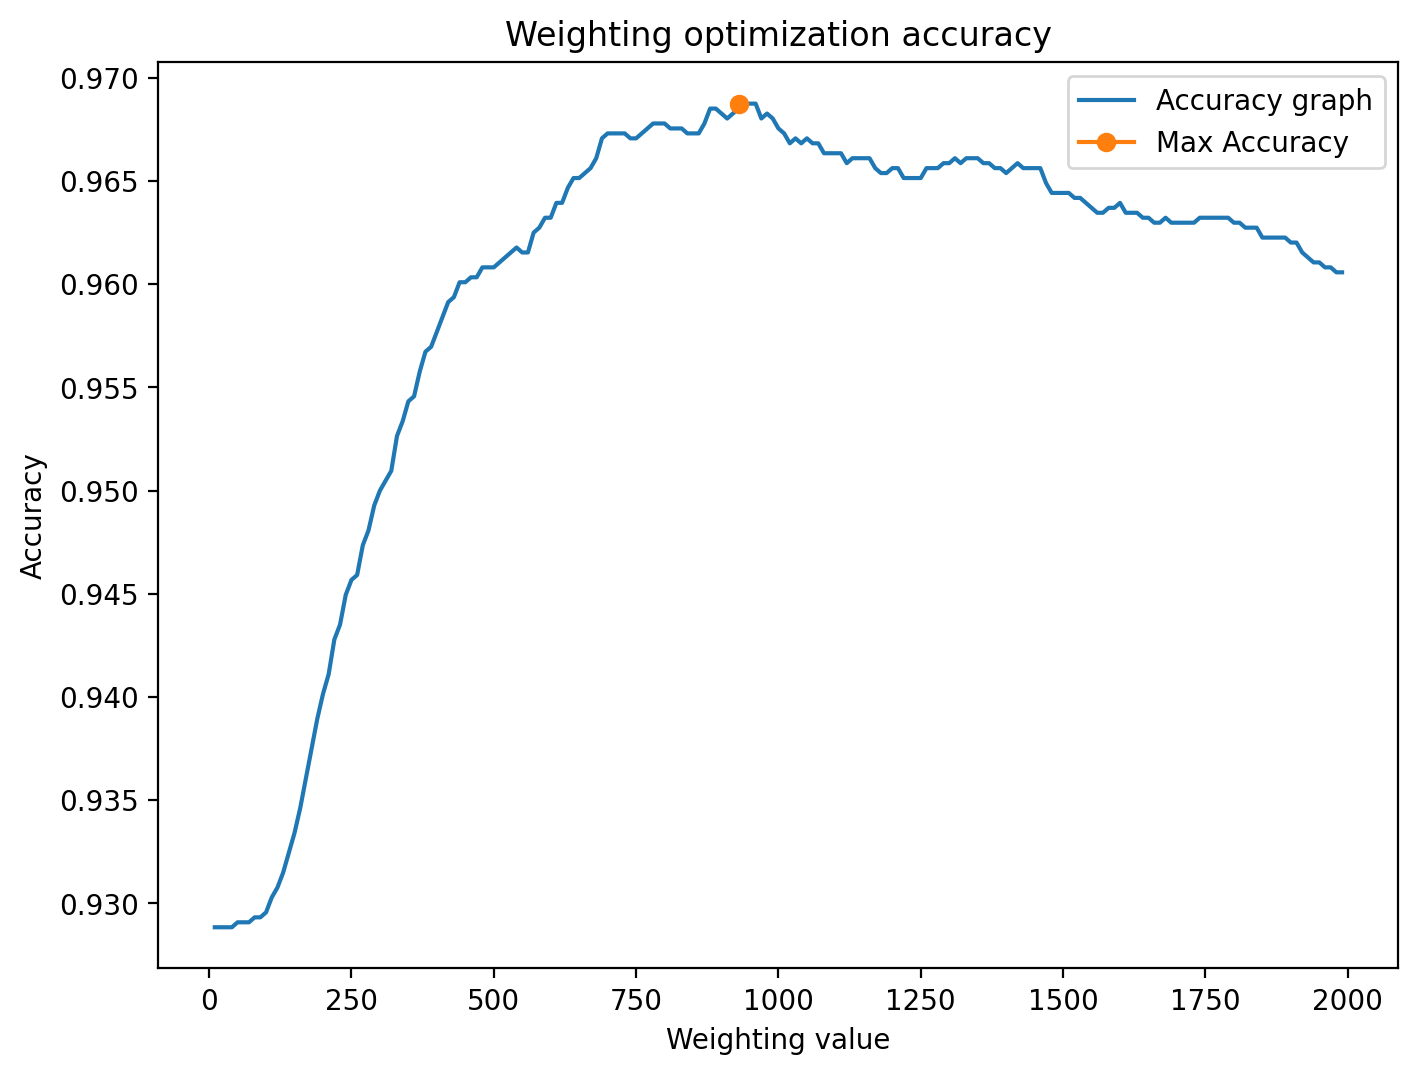

In [54]:
figure(figsize=(8, 6), dpi=200)
plt.plot([x*10 for x in weighting_count], weighting_result_accuracys, label="Accuracy graph")
plt.plot(best_weight*10, best_weight_accuracy, marker="o", label = "Max Accuracy")
plt.title("Weighting optimization accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Weighting value")
plt.legend()
plt.savefig("../reports/figures/Validation_Weighting_Diagram.png")

In [55]:
softmax_probas = []
softmax_text_probas = []
combined_softmax_probas = []
for i in range(0, len(probas)):
    softmax_probas.append(softmax(probas[i]))
    softmax_text_probas.append(softmax(text_dec_probas[i])*10 *best_weight) #100*12
    combined_softmax_probas.append(softmax_probas[-1]+ softmax_text_probas[-1])

combined_probas = combined_softmax_probas

top_k_number = 1
top_k_acc, top_k_results, combined_indexes, combined_real_class_indexes = top_k_calc_from_probas(combined_probas, df_text_pred["truth_labels"].values, top_k_number)
result_df["in_top_" + str(top_k_number)] = top_k_results
print(top_k_acc)

0.9685096153846153


In [56]:
best_image_probas = []
best_text_probas = []
for i in range(0, len(image_indexes)):
    best_image_probas.append(softmax_probas[i][image_indexes[i][0]])
    best_text_probas.append(softmax_text_probas[i][text_indexes[i][0]])

In [57]:
results = []
high_conf = []
low_conf = []
for i in range(0, len(best_text_probas)):
    if text_indexes[i][0] == image_indexes[i][0]:
        results.append(int(text_indexes[i][0]))
        high_conf.append(int(text_indexes[i][0]) == df_text_pred["truth_labels"].values[i])
    else:
        results.append(combined_indexes[i][0])
        low_conf.append(combined_indexes[i][0] == df_text_pred["truth_labels"].values[i])

In [58]:
print("Combine Accuracy")
list(results == df_text_pred["truth_labels"].values).count(True)/len(df_text_pred)

Combine Accuracy


0.9685096153846153

In [59]:
print("Percentage of Data - Models same result")
print(len(high_conf)/len(best_text_probas))

print("Percentage of Data - Models same result - Accuracy")
print(list(high_conf).count(True)/len(high_conf))

Percentage of Data - Models same result
0.8831730769230769
Percentage of Data - Models same result - Accuracy
0.9880239520958084


In [60]:
print("Percentage of Data - Models not the same")
print(len(low_conf)/len(best_text_probas))

print("Percentage of Data - Models not the same - Accuracy")
print(list(low_conf).count(True)/len(low_conf))

Percentage of Data - Models not the same
0.11682692307692308
Percentage of Data - Models not the same - Accuracy
0.8209876543209876


In [61]:
combined_probas = combined_softmax_probas

top_k_number = 1
top_k_acc, top_k_results, combined_indexes, combined_real_class_indexes = top_k_calc_from_probas(combined_probas, df_text_pred["truth_labels"].values, top_k_number)
result_df["in_top_" + str(top_k_number)] = top_k_results

print("Accuracy Top - " + str(top_k_number))
top_k_acc

Accuracy Top - 1


0.9685096153846153

In [62]:
combined_probas = combined_softmax_probas

top_k_number = 3
top_k_acc, top_k_results, combined_indexes, combined_real_class_indexes = top_k_calc_from_probas(combined_probas, df_text_pred["truth_labels"].values, top_k_number)
result_df["in_top_" + str(top_k_number)] = top_k_results

print("Accuracy Top - " + str(top_k_number))
top_k_acc

Accuracy Top - 3


0.9942307692307693

In [63]:
combined_probas = combined_softmax_probas

top_k_number = 5
top_k_acc, top_k_results, combined_indexes, combined_real_class_indexes = top_k_calc_from_probas(combined_probas, df_text_pred["truth_labels"].values, top_k_number)
result_df["in_top_" + str(top_k_number)] = top_k_results

print("Accuracy Top - " + str(top_k_number))
top_k_acc

Accuracy Top - 5


0.9951923076923077

# Test

## Image Test

In [64]:
# get Image Order from dataloader to keep order
selected_dataloader = pRMModel.dataloaders["test"]
test_image_paths = selected_dataloader.dataset.imgs
test_image_model_labels = [x[1] for x in test_image_paths]
test_image_paths = [x[0] for x in test_image_paths]
test_image_paths_512 = [x.replace("_256", "_512") for x in test_image_paths]

df_test_images = pd.DataFrame()
df_test_images["image_paths"] = test_image_paths_512

result_df = pd.DataFrame()
result_df["image_paths"] = test_image_paths
result_df["truth_labels"] = test_image_model_labels

In [65]:
%%time
# predict by dataloader
result, probas = pRMModel.predict_from_dataloader_probas(selected_dataloader)
confidence = [x[0] for x in result]
predictions = [x[1] for x in result]
result_df["image_confidence"] = confidence
result_df["image_prediction"] = predictions

CPU times: user 3min 43s, sys: 2.5 s, total: 3min 46s
Wall time: 28.3 s


In [66]:
top_k_number = 1
top_k_acc, top_k_results, image_indexes, _ = top_k_calc_from_probas(probas, result_df["truth_labels"].values, top_k_number)
result_df["in_top_" + str(top_k_number)] = top_k_results
top_k_acc

0.9254807692307693

In [67]:
top_k_number = 3
top_k_acc, top_k_results, image_indexes, _ = top_k_calc_from_probas(probas, result_df["truth_labels"].values, top_k_number)
result_df["in_top_" + str(top_k_number)] = top_k_results
top_k_acc

0.9663461538461539

In [68]:
top_k_number = 5
top_k_acc, top_k_results, image_indexes, _ = top_k_calc_from_probas(probas, result_df["truth_labels"].values, top_k_number)
result_df["in_top_" + str(top_k_number)] = top_k_results
top_k_acc

0.9725961538461538

## Text Test

In [69]:
df_text_pred = df_test.copy()

In [70]:
#sort to adjust order to image dataloader prediction
df_text_pred = df_text_pred.sort_values("image_id").reset_index(drop=True)

truth_indexes = []
for i in df_text_pred["truth_labels"].values:
    truth_indexes.append(selected_dataloader.dataset.class_to_idx[i])
df_text_pred["truth_labels"] = truth_indexes
#df_text_pred.to_pickle(save_path + "df_test_sorted" +".pkl")

In [71]:
transformation = text_model.transform(df_text_pred["ocr_all"])
text_preds = text_model.predict(transformation)
text_probas = text_model.model.predict_proba(transformation)
text_dec_probas = text_model.model.decision_function(transformation)

result_df["text_prediction"] = text_preds

In [72]:
top_k_number = 1
top_k_acc, top_k_results, text_indexes, _ = top_k_calc_from_probas(text_dec_probas, df_text_pred["truth_labels"].values, top_k_number)
result_df["in_top_" + str(top_k_number)] = top_k_results

result_df["text_in_top_1"] = top_k_results
top_k_acc

0.9204326923076923

## Test Combine

In [73]:
softmax_probas = []
softmax_text_probas = []
combined_softmax_probas = []
for i in range(0, len(probas)):
    softmax_probas.append(softmax(probas[i]))
    softmax_text_probas.append(softmax(text_dec_probas[i])*10 *best_weight) #100*12
    combined_softmax_probas.append(softmax_probas[-1]+ softmax_text_probas[-1])

combined_probas = combined_softmax_probas

top_k_number = 1
top_k_acc, top_k_results, combined_indexes, combined_real_class_indexes = top_k_calc_from_probas(combined_probas, df_text_pred["truth_labels"].values, top_k_number)
result_df["in_top_" + str(top_k_number)] = top_k_results
print(top_k_acc)

0.9668269230769231


In [74]:
best_image_probas = []
best_text_probas = []
for i in range(0, len(image_indexes)):
    best_image_probas.append(softmax_probas[i][image_indexes[i][0]])
    best_text_probas.append(softmax_text_probas[i][text_indexes[i][0]])

In [75]:
results = []
high_conf = []
low_conf = []
for i in range(0, len(best_text_probas)):
    if text_indexes[i][0] == image_indexes[i][0]:
        results.append(int(text_indexes[i][0]))
        high_conf.append(int(text_indexes[i][0]) == df_text_pred["truth_labels"].values[i])
    else:
        results.append(combined_indexes[i][0])
        low_conf.append(combined_indexes[i][0] == df_text_pred["truth_labels"].values[i])

In [76]:
print("Combine Accuracy")
list(results == df_text_pred["truth_labels"].values).count(True)/len(df_text_pred)

Combine Accuracy


0.9668269230769231

In [77]:
print("Percentage of Data - Models same result")
print(len(high_conf)/len(best_text_probas))

print("Percentage of Data - Models same result - Accuracy")
print(list(high_conf).count(True)/len(high_conf))

Percentage of Data - Models same result
0.8764423076923077
Percentage of Data - Models same result - Accuracy
0.9871091607240812


In [78]:
print("Percentage of Data - Models not the same")
print(len(low_conf)/len(best_text_probas))

print("Percentage of Data - Models not the same - Accuracy")
print(list(low_conf).count(True)/len(low_conf))

Percentage of Data - Models not the same
0.12355769230769231
Percentage of Data - Models not the same - Accuracy
0.8229571984435797


In [79]:
combined_probas = combined_softmax_probas

top_k_number = 1
top_k_acc, top_k_results, combined_indexes, combined_real_class_indexes = top_k_calc_from_probas(combined_probas, df_text_pred["truth_labels"].values, top_k_number)
result_df["in_top_" + str(top_k_number)] = top_k_results

print("Accuracy Top - " + str(top_k_number))
top_k_acc

Accuracy Top - 1


0.9668269230769231

In [80]:
combined_probas = combined_softmax_probas

top_k_number = 3
top_k_acc, top_k_results, combined_indexes, combined_real_class_indexes = top_k_calc_from_probas(combined_probas, df_text_pred["truth_labels"].values, top_k_number)
result_df["in_top_" + str(top_k_number)] = top_k_results

print("Accuracy Top - " + str(top_k_number))
top_k_acc

Accuracy Top - 3


0.9913461538461539

In [81]:
combined_probas = combined_softmax_probas

top_k_number = 5
top_k_acc, top_k_results, combined_indexes, combined_real_class_indexes = top_k_calc_from_probas(combined_probas, df_text_pred["truth_labels"].values, top_k_number)
result_df["in_top_" + str(top_k_number)] = top_k_results

print("Accuracy Top - " + str(top_k_number))
top_k_acc

Accuracy Top - 5


0.9944711538461538